### [전이학습] 개 고양이 classification

* 데이터 출처 : https://www.kaggle.com/datasets/aleemaparakatta/cats-and-dogs-mini-dataset

## 1. 환경 설정 및 데이터 준비

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# 데이터 경로 설정 (학생들은 자신의 경로로 수정)
BASE_DIR = '../data/cats_and_dogs/'
train_dir = os.path.join(BASE_DIR, 'train/')
val_dir = os.path.join(BASE_DIR, 'validation/')

# 데이터 증강 및 기본 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    # target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    # target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

print('데이터 준비 완료!')

Found 814 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
데이터 준비 완료!


## 2. 모델 구성
MobileNetV2, VGG16, ResNet50 중 하나를 선택해 전이학습 모델을 구성합니다.
- MobileNetV2: 경량화, 빠른 학습 (기본 선택)
- VGG16: 단순하고 깊은 구조, 높은 메모리 사용
- ResNet50: 잔차 연결로 깊은 학습 가능, 중간 속도

*실험*: 아래에서 원하는 모델을 선택해 주석을 해제하고 실행해보세요.

In [11]:
# 모델 선택 (기본: MobileNetV2)
# 1. MobileNetV2
image_size = 224    # 128, 150, ...
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model_name = 'MobileNetV2'

# # 2. VGG16
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# model_name = 'VGG16'

# # 3. ResNet50
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# model_name = 'ResNet50'

# 학습 가능 층 설정 (마지막 10개 층만 학습)
base_model.trainable = True             # base model도 파라미터 학습으로 설정
for layer in base_model.layers[:-10]:   # base model의 앞부분 10개 layer는 학습 불가로 재설정
    layer.trainable = False

# base_model.summary()


In [12]:

# 모델 구성
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일 (낮은 학습률 사용)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 요약
print(f'선택된 모델: {model_name}')
model.summary()

선택된 모델: MobileNetV2


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 896,577 (3.42 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

## 3. 데이터 증강 및 학습

In [13]:
%%time
# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, 
                               restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(f'best_model_{model_name}.keras', monitor='val_loss', 
                             save_best_only=True, verbose=1)

# 학습
history = model.fit(
    train_generator,
    steps_per_epoch=62,   # 데이터 수 // 배치사이즈
    epochs=20,
    validation_data=validation_generator,
    validation_steps=12,   
    callbacks=[early_stopping, checkpoint]
)

print('학습 완료!')

Epoch 1/20
51/62 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - accuracy: 0.7477 - loss: 0.5043

C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from None to 0.09129, saving model to best_model_MobileNetV2.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 507ms/step - accuracy: 0.8501 - loss: 0.3335 - val_accuracy: 0.9839 - val_loss: 0.0913
Epoch 2/20
51/62 ━━━━━━━━━━━━━━━━━━━━ 5s 479ms/step - accuracy: 0.9342 - loss: 0.1900
Epoch 2: val_loss improved from 0.09129 to 0.07115, saving model to best_model_MobileNetV2.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 465ms/step - accuracy: 0.9410 - loss: 0.1687 - val_accuracy: 0.9839 - val_loss: 0.0712
Epoch 3/20
51/62 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - accuracy: 0.9652 - loss: 0.1280
Epoch 3: val_loss did not improve from 0.07115
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 479ms/step - accuracy: 0.9582 - loss: 0.1228 - val_accuracy: 0.9785 - val_loss: 0.0765
Epoch 4/20
51/62 ━━━━━━━━━━━━━━━━━━━━ 5s 513ms/step - accuracy: 0.9837 - loss: 0.0592
Epoch 4: val_loss improved from 0.07115 to 0.06335, saving model to best_model_MobileNetV2.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 493ms/step - accuracy

## 4. 결과 확인 및 평가

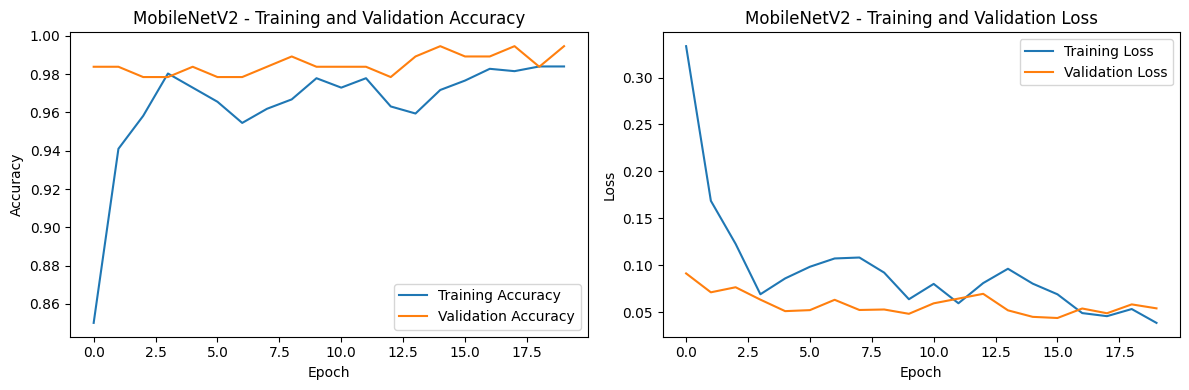

In [14]:
# 정확도와 손실 그래프
plt.figure(figsize=(12, 4))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{model_name} - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


* 검증 데이터 로 예측해보기

In [15]:
# 검증 데이터에 대한 예측
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=12)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = validation_generator.classes[:len(y_pred_classes)]
y_true

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 442ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

* 혼동 행렬 (Confusion Matrix)

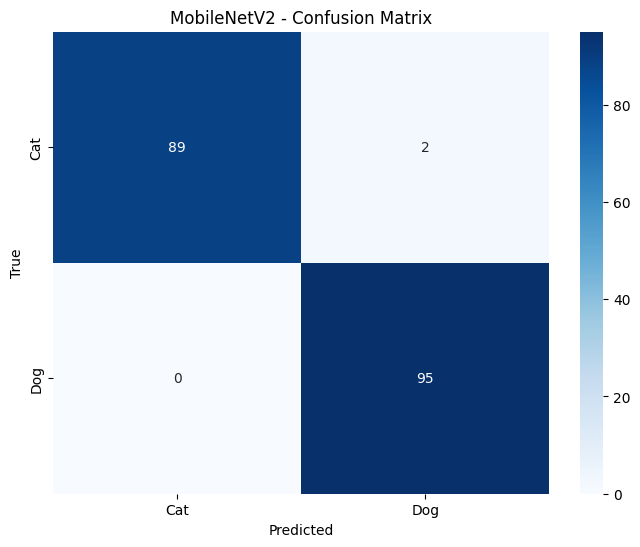

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title(f'{model_name} - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

* 평가 지표 (Accuracy(정확도), Precision(정밀도), Recall(재현율), F1-Score) 분석

In [17]:
train_generator.class_indices.keys()

dict_keys(['cat', 'dog'])

In [18]:
# Classification Report (Accuracy, Precision, Recall, F1 Score)
report = classification_report(y_true, y_pred_classes, target_names=['Cat', 'Dog'])  # train_generator.class_indices.keys()
print(f'{model_name} - Classification Report:')
print(report)

MobileNetV2 - Classification Report:
              precision    recall  f1-score   support

         Cat       1.00      0.98      0.99        91
         Dog       0.98      1.00      0.99        95

    accuracy                           0.99       186
   macro avg       0.99      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186



In [19]:
report

'              precision    recall  f1-score   support\n\n         Cat       1.00      0.98      0.99        91\n         Dog       0.98      1.00      0.99        95\n\n    accuracy                           0.99       186\n   macro avg       0.99      0.99      0.99       186\nweighted avg       0.99      0.99      0.99       186\n'

## 5. 새로운 이미지로 예측해 보기

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# 예측 함수
def predict_image(model, img_path):
    # img = load_img(img_path, target_size=(128, 128))
    img = load_img(img_path, target_size=(image_size, image_size)) # 224, 224
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    return 'Dog' if pred > 0.5 else 'Cat'

# 예시 이미지 예측
sample_img_path = '../data/images/1.png'  # 학생들은 자신의 이미지 경로로 수정
result = predict_image(model, sample_img_path)
print(f'{model_name} - 예측 결과: {result}')

Image.open(sample_img_path)

ModuleNotFoundError: No module named 'PLT'

**[과제]**  
- 자신의 개/고양이 이미지를 모델로 예측해보자.  

- MobileNetV2, VGG16, ResNet50 중 다른 모델을 선택해 학습하고 결과를 비교해보세요
  
**[질문]**
1. 데이터 증강이 모델 성능에 어떤 영향을 미쳤나?  
  
2. 학습 시간이 더 있다면 어떤 변화를 시도할까? (예: 층 추가, 학습률 조정 등)  
3. MobileNetV2, VGG16, ResNet50 중 어떤 모델이 가장 효과적이었나? 이유는?'

#### **새로운 이미지로 예측해 보기**

In [ ]:
import numpy as np
from PIL import Image

import glob
img_paths = glob.glob('../cnn_data/images/*.*')
images = []
PIL_images = []
for path in img_paths:
    image = plt.imread(path)
    images.append(image)
    PIL_img = Image.open(path)
    PIL_images.append(PIL_img.resize((image_size, image_size)))
plt.imshow(image)
plt.show()

In [ ]:
PIL_images

In [ ]:
train_generator.class_indices

In [ ]:
classes = ['냥이', '댕이']
for p_img in PIL_images:
    display(p_img)
    img_arr = np.array(p_img.convert('RGB'))[np.newaxis, :, :, :] / 255.  # 정규화
    predicted = model.predict(img_arr, verbose=0).round(3)[0][0]
    print(predicted, classes[int((predicted > 0.5) * 1)])